Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import time
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as ltb
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier


## Data preparation

In [67]:
try:
    df = pd.read_csv('/datasets/car_data.csv')
except:
    df = pd.read_csv(r"C:\Users\vlady\Downloads\car_data.csv")
    
print('Data train_raw has been read correctly!')


Data train_raw has been read correctly!


In [68]:
def inspector(df):
    print("---------------------------")
    df.columns = df.columns.str.lower()
    print("NUMBER OF COLUMNS:", len(df.columns))
    print(f"NUMBER OF ROWS", len(df))
    print("NUMBER OF DUPLICATES:", df.duplicated().sum())
    print("---------------------------")
    print("NUMBER OF NANS:\n")
    print(df.isna().sum())
    print(" ")

inspector(df)


---------------------------
NUMBER OF COLUMNS: 16
NUMBER OF ROWS 354369
NUMBER OF DUPLICATES: 262
---------------------------
NUMBER OF NANS:

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
mileage                  0
registrationmonth        0
fueltype             32895
brand                    0
notrepaired          71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64
 


We have 5 columns with multiple missing values. Let's do a data imputation to the missing values. 

In [69]:
def fill_with_mode(column, column1, column2):
    df[column] = df.groupby([column1, column2])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))
  

In [70]:
fill_with_mode('model','brand','registrationyear')
fill_with_mode('vehicletype','brand','model')
fill_with_mode('fueltype','brand','model')
fill_with_mode('gearbox','brand','model')

In [71]:
df.isna().sum()

datecrawled              0
price                    0
vehicletype              0
registrationyear         0
gearbox                  0
power                    0
model                    0
mileage                  0
registrationmonth        0
fueltype                 0
brand                    0
notrepaired          71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

We recieved a few "Empty" instances in the gearbox. 

In [72]:
df["gearbox"].value_counts()

manual    285937
auto       68411
Empty         21
Name: gearbox, dtype: int64

In [73]:
# Let's drop these instances:
df.drop(df.loc[df["gearbox"]=="Empty"].index, inplace=True)


In [74]:
# Let's asign yes to all the notrepaired nans instances and then asign a numeric
df["notrepaired"] = df["notrepaired"].fillna('yes')
df["notrepaired"] = (df["notrepaired"] == 'yes').astype('int')

In [75]:
df["notrepaired"].value_counts()

0    247157
1    107191
Name: notrepaired, dtype: int64

In [76]:
df.isna().sum()

datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
mileage              0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Ok, this can be a valid approach, but keep in mind that sometimes customer wants the model to work even if some of the values are missing

</div>

Let's also drop 262 duplicates:

In [77]:
df = df.drop_duplicates()

<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright!

</div>

In [78]:
def inspector(df):
    print("---------------------------")
    df.columns = df.columns.str.lower()
    print("NUMBER OF COLUMNS:", len(df.columns))
    print(f"NUMBER OF ROWS", len(df))
    print("NUMBER OF DUPLICATES:", df.duplicated().sum())
    print("---------------------------")
    print("NUMBER OF NANS:\n")
    print(df.isna().sum())
    print(" ")

inspector(df)

---------------------------
NUMBER OF COLUMNS: 16
NUMBER OF ROWS 354074
NUMBER OF DUPLICATES: 0
---------------------------
NUMBER OF NANS:

datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
mileage              0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64
 


In [79]:
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,24/03/2016 11:52,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,1,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,1,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,1,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0,31/03/2016 00:00,0,60437,06/04/2016 10:17


There are columns that have no influece on the price (prediction target) Let's get rid of them:

In [80]:
df.drop(columns = ["datecrawled", "lastseen", "datecreated", "numberofpictures", "registrationmonth", "postalcode" ], inplace = True)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Makes sense!

</div>

In [81]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,mileage,fueltype,brand,notrepaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,1
1,18300,coupe,2011,manual,190,a4,125000,gasoline,audi,1
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,1
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0


Lets inspect the data visually:

2700.0

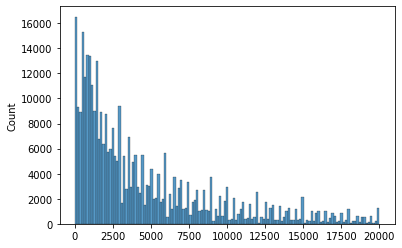

In [82]:
import seaborn as sns
sns.histplot(df.price.values)
np.median(df.price.values)

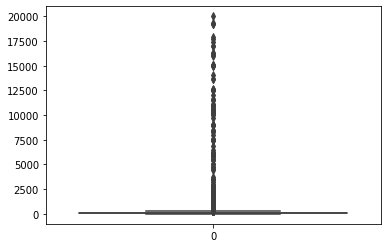

In [83]:
sns.boxplot(data=df['power']);

There's something very strange going on in the power column. Let's take a closer look:

Text(0.5, 1.0, 'power')

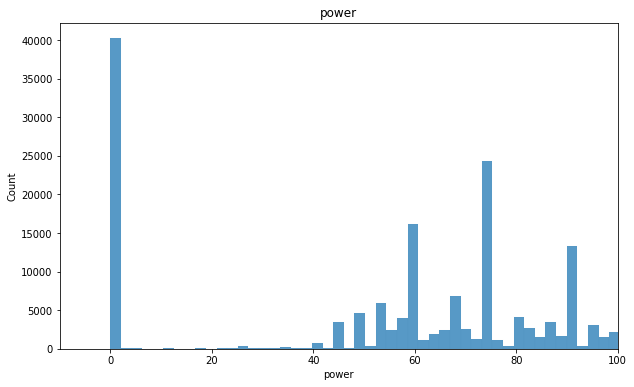

In [84]:
plt.figure(figsize=(10,6))
sns.histplot(df.power)
plt.xlim(-10, 100)
plt.title("power") 

In [85]:
len(df[df.power == 0])

40202

According to Autolist.com, the average horsepower for a vehicle falls somewhere between 180 and 200 horsepower, typically falling below 200. The LEAST powerful car available today is the Mitsubishi Mirage, with its 1.2-liter three-cylinder engine providing just 78 horse power. Yet we have over 50K of vehicles between power 0 (not including 0) and 70 and about 40K cars with 0 horse power (i.e.power)


In [86]:
len(df[(df.power > 0) & (df.power < 70)])

51753

In [87]:
len(df[(df.power == 0)])

40202

Let's asign "Nans" to all these values and then impute based on other instances in the dataset:

In [88]:
df.loc[df.power <= 70, "power"] = np.nan

In [89]:
# Check
len(df[df.power <= 70])

0

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354074 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   price             354074 non-null  int64  
 1   vehicletype       354074 non-null  object 
 2   registrationyear  354074 non-null  int64  
 3   gearbox           354074 non-null  object 
 4   power             261033 non-null  float64
 5   model             354074 non-null  object 
 6   mileage           354074 non-null  int64  
 7   fueltype          354074 non-null  object 
 8   brand             354074 non-null  object 
 9   notrepaired       354074 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 37.8+ MB


In [91]:
def fill_with_numerics(column, column1, column2):
    df[column] = df.groupby([column1, column2])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else np.nan)))
  

let's try to find the horse power by brand and model:

In [92]:
fill_with_numerics('power','brand','model')
df.power.isna().sum()

530

We still got a few left. Let's try with other columns:

In [93]:
fill_with_numerics('power','model','registrationyear')
df.power.isna().sum()

514

Let's drop these guys

In [94]:
df.dropna(inplace = True)

Great. We can move on now. 

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353560 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   price             353560 non-null  int64  
 1   vehicletype       353560 non-null  object 
 2   registrationyear  353560 non-null  int64  
 3   gearbox           353560 non-null  object 
 4   power             353560 non-null  float64
 5   model             353560 non-null  object 
 6   mileage           353560 non-null  int64  
 7   fueltype          353560 non-null  object 
 8   brand             353560 non-null  object 
 9   notrepaired       353560 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 29.7+ MB


Text(0.5, 1.0, 'power')

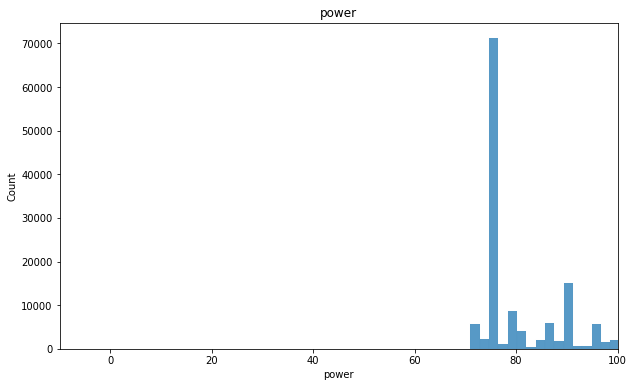

In [96]:
# Visualy check
plt.figure(figsize=(10,6))
sns.histplot(df.power)
plt.xlim(-10, 100)
plt.title("power") 

Let's one hot encode the categorical columns:

In [97]:
df = pd.get_dummies(df, drop_first=True)

df

,price,registrationyear,power,mileage,notrepaired,vehicletype_bus,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,...,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
0,480,1993,75.0,150000,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,18300,2011,190.0,125000,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9800,2004,163.0,125000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75.0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3600,2008,75.0,90000,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,2005,75.0,150000,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
354365,2200,2005,140.0,20000,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
354366,1199,2000,101.0,125000,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
354367,9200,1996,102.0,150000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


<div class="alert alert-success">
<b>Reviewer's comment</b>

Categorical features were encoded

</div>

In [98]:
features  = df.drop(columns= "price")
target =  df.price

In [99]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3)

Let's scale (normalize) the values in ["registrationyear","power","mileage"] columns

In [100]:
from sklearn.preprocessing import StandardScaler
cols = ["registrationyear","power","mileage"]
scaler = StandardScaler()
#scaled = scaler.fit_transform(X_train[cols])
scaled_columns = scaler.fit_transform(X_train[cols])
scaled_columns

array([[ 0.00564311, -0.00707318, -1.27528717],
       [-0.12956474, -0.29755558, -0.74688826],
       [-0.0151581 , -0.23838324,  0.57410904],
       ...,
       [-0.0255587 ,  0.3802367 ,  0.57410904],
       [-0.0255587 ,  0.35871949,  0.57410904],
       [-0.18156775, -0.10390065,  0.57410904]])

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

It's problematic to apply scaling to the whole dataset due to data leakage. The correct way is to first split the data, fit the scaler using the train set and then use it to transform train/validation/test, or if you use cross-validation scale each fold separately (the simplest way to achieve that is to use [pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html))

</div>

A very subtle point! I wouldnt think about it.

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Yeah, it is! :)

</div>

In [101]:
pd.options.mode.chained_assignment = None

X_train[cols] = scaled_columns
X_train

,registrationyear,power,mileage,notrepaired,vehicletype_bus,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,...,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
194627,0.005643,-0.007073,-1.275287,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
319739,-0.129565,-0.297556,-0.746888,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
333851,-0.015158,-0.238383,0.574109,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
220332,-0.056761,-0.033970,0.574109,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
225716,-0.067161,-0.195349,0.574109,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315007,0.120050,-0.222245,-3.256783,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
272039,-0.056761,-0.136176,0.574109,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101926,-0.025559,0.380237,0.574109,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
353347,-0.025559,0.358719,0.574109,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
pd.options.mode.chained_assignment = None
X_test[cols] = scaler.transform(X_test[cols])
# X_test[cols]

In [103]:
X_test

,registrationyear,power,mileage,notrepaired,vehicletype_bus,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,...,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
245790,-0.462384,-0.055487,0.574109,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117705,-0.025559,-0.136176,0.574109,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95973,0.005643,0.100513,0.574109,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79708,-0.067161,-0.060866,0.574109,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
213140,0.005643,0.342582,0.574109,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169790,-0.056761,-0.023211,0.574109,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
334730,-0.015158,-0.028590,0.574109,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3019,-0.035959,-0.297556,-0.086390,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
150330,0.036845,-0.276038,-2.067886,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split into train and test

</div>

Let's build models:

## Model training

### LINEAR REGRESSOR AS PERFORMANCE BENCHMARK

In [104]:
linear = LinearRegression()
linear.fit(X_train, y_train)
l_pred = linear.predict(X_test)
l_rmse = sqrt(mean_squared_error(y_test, l_pred ))
print("Linear model RMSE = ", round(l_rmse,2))

Linear model RMSE =  3203.11


### Random Forest Regressor

In [105]:
forest = RandomForestRegressor(n_estimators = 9)
forest.fit(X_train, y_train)
preds = forest.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, preds ))
print("Forest model RMSE = ", round(rmse,2))


Forest model RMSE =  1844.19


### GRADIENT BOOSTING REGRESSOR

In [106]:
boosted_model = GradientBoostingRegressor(random_state=0, n_estimators = 9 )
boosted_model.fit(X_train, y_train)
boosted_preds = boosted_model.predict(X_test)
boosted_rmse = sqrt(mean_squared_error(y_test, boosted_preds ))
print("Boosting Regressor RMSE = ", round(boosted_rmse,2))

Boosting Regressor RMSE =  3153.57


### CATBOOST REGRESSOR

In [107]:
model_cb = CatBoostRegressor(random_state = 12345, iterations = 10)
parameters_cb = {'depth': range(6, 11),
                 'learning_rate': [0.001, 0.01, 0.05, 0.1]}
search_cb = RandomizedSearchCV(model_cb, parameters_cb, cv = 5, n_jobs = -1, random_state = 12345)
search_cb.fit(X_train, y_train, verbose = 100)
best_cb = search_cb.best_estimator_
predict_cb_valid = best_cb.predict(X_test)
rmse_cb_valid = mean_squared_error(y_test, predict_cb_valid)**0.5
print('The quality of CatBoost on the test dataset, measured in RMSE is :', rmse_cb_valid)

0:	learn: 4481.8479712	total: 55ms	remaining: 495ms
9:	learn: 4224.6207222	total: 396ms	remaining: 0us
0:	learn: 4487.0362657	total: 47.3ms	remaining: 426ms
9:	learn: 4230.4532562	total: 392ms	remaining: 0us
0:	learn: 4482.8610530	total: 43.5ms	remaining: 392ms
9:	learn: 4225.4795811	total: 387ms	remaining: 0us
0:	learn: 4495.0610230	total: 41.7ms	remaining: 375ms
9:	learn: 4237.7504806	total: 374ms	remaining: 0us
0:	learn: 4479.6972238	total: 33.2ms	remaining: 299ms
9:	learn: 4223.9363234	total: 375ms	remaining: 0us
0:	learn: 4509.4559517	total: 35.8ms	remaining: 322ms
9:	learn: 4482.7074970	total: 324ms	remaining: 0us
0:	learn: 4514.8845633	total: 29.2ms	remaining: 263ms
9:	learn: 4488.1779306	total: 320ms	remaining: 0us
0:	learn: 4510.4456564	total: 34.6ms	remaining: 311ms
9:	learn: 4483.6549556	total: 339ms	remaining: 0us
0:	learn: 4522.8439376	total: 34.6ms	remaining: 311ms
9:	learn: 4496.1517332	total: 324ms	remaining: 0us
0:	learn: 4507.3528618	total: 31.2ms	remaining: 281ms
9:	

## Model analysis

### Linear Regression

In [108]:
%%time
start_linear_fit = time.time()
linear.fit(X_train, y_train)
end_linear_fit = time.time()
time_linear_fit = end_linear_fit - start_linear_fit

start_linear_predict = time.time()
predict_linear_test = linear.predict(X_test)
end_linear_predict = time.time()
time_linear_predict = end_linear_predict - start_linear_predict
rmse_linear_test = mean_squared_error(y_test, predict_linear_test)**0.5


CPU times: user 21.3 s, sys: 43.7 s, total: 1min 5s
Wall time: 1min 5s


### CatBoost

In [109]:
%%time
start_cb_fit = time.time()
best_cb.fit(X_train, y_train, verbose = 100)
end_cb_fit = time.time()
time_cb_fit = end_cb_fit - start_cb_fit

start_cb_predict = time.time()
predict_cb_test = best_cb.predict(X_test)
end_cb_predict = time.time()
time_cb_predict = end_cb_predict - start_cb_predict
rmse_cb_test = mean_squared_error(y_test, predict_cb_test)**0.5


0:	learn: 4216.2417119	total: 47.6ms	remaining: 428ms
9:	learn: 2745.8047776	total: 489ms	remaining: 0us
CPU times: user 1.82 s, sys: 43.4 ms, total: 1.87 s
Wall time: 2.54 s


### Random Forest

In [110]:
%%time
start_forest_fit = time.time()
forest.fit(X_train, y_train)
end_forest_fit = time.time()
time_forest_fit = end_forest_fit - start_forest_fit

start_forest_predict = time.time()
predict_forest_test = forest.predict(X_test)
end_forest_predict = time.time()
time_forest_predict = end_forest_predict - start_forest_predict

rmse_forest_test = mean_squared_error(y_test, predict_forest_test)**0.5

CPU times: user 46.6 s, sys: 403 ms, total: 47 s
Wall time: 47.2 s


### Gradient Boosting Regressor

In [111]:

%%time
start_bo_fit = time.time()
boosted_model.fit(X_train, y_train)
end_bo_fit = time.time()
time_bo_fit = end_bo_fit - start_bo_fit

start_bo_predict = time.time()
predict_bo_test = boosted_model.predict(X_test)
end_bo_predict = time.time()
time_bo_predict = end_bo_predict - start_bo_predict

rmse_bo_test = mean_squared_error(y_test, predict_bo_test)**0.5

CPU times: user 12.4 s, sys: 440 ms, total: 12.8 s
Wall time: 12.8 s


<div class="alert alert-success">
<b>Reviewer's comment</b>

Excellent, you measured both training and prediction time

</div>

A model analysis of five different regressional models composes a challenge since we can not use a unified parameters to all. Linear regression for instance does not use the hyperparameters of the boosting regeressor. Thus, the training times will differ significantly. With that said, given that our app uses pre trained model that is embedded within the end device (or stored on the cloud) we can talk, in general, about the overall quality of the models using time and RMSE of predictions as our metrics.


In [112]:
results = pd.DataFrame([{"model": "Random Forest Regressor", "Prediction time": time_forest_predict, "Training time": time_forest_fit,"RMSE": rmse_forest_test},
                        {"model": "LINEAR REGRESSOR", "Prediction time":  time_linear_predict,"Training time": time_linear_fit ,"RMSE": rmse_linear_test},
                        {"model": "CAT REGRESSOR", "Prediction time": time_cb_predict, "Training time": time_cb_fit ,"RMSE": rmse_cb_test},
                        {"model": "Boosting Regressor", "Prediction time": time_bo_predict, "Training time": time_bo_fit, "RMSE": rmse_bo_test},
                       ]
)
results.sort_values(by='RMSE', ascending=True)

,model,Prediction time,Training time,RMSE
0,Random Forest Regressor,0.647574,46.511063,1839.183041
2,CAT REGRESSOR,0.013127,2.521965,2748.390681
3,Boosting Regressor,0.304107,12.530996,3153.570438
1,LINEAR REGRESSOR,0.206840,64.862638,3203.109415


Measuring the quality of our model by prediction time and RMSE, the CAT regressor has a significant advantage over other models both in the prediction time and the RMSE score.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Well done!

</div>

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed